## Using ATHENA fastsim (Delphes) as input

Trying out things from Ben Nachman's example.

This uses the ATHENA fastsim MC as input.

Uses set of variables is E, pt, pz, Empz (redundant but useful?) for both HFS and electron as well as delta phi between HFS and electron.

Main development changes here:

Added two more layers to NN and reduced dropout from 0.2 to 0.1

Training target variable is log(x) instead of x





In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl



/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

#--- Number of events to use in training.
#max_events = 2e7
max_events = 2e6
#max_events = 4e7


#--- Hyperparameter settings.
#learning_rate_setval = 1e-4
#batch_size_setval = 128
#max_epochs = 5000


#learning_rate_setval = 1e-4
#batch_size_setval = 64
#max_epochs = 5000

#learning_rate_setval = 1e-4
#batch_size_setval = 1024
#max_epochs = 5000

learning_rate_setval = 1e-4
batch_size_setval = 256
max_epochs = 5000

#learning_rate_setval = 1e-5
#batch_size_setval = 256
#max_epochs = 5000




In [3]:
%%time


input_file = 'mini-tree-athena-ef-no-noise-1m.root'

ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
ur_tree.show()


pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

[b'minitree;7', b'minitree;6']
<TTree b'minitree' at 0x00010ac6bca0>
Q2_e                       (no streamer)              asdtype('>f4')
Q2_sigma                   (no streamer)              asdtype('>f4')
Q2_esigma                  (no streamer)              asdtype('>f4')
Q2_da                      (no streamer)              asdtype('>f4')
gen_Q2                     (no streamer)              asdtype('>f4')
y_e                        (no streamer)              asdtype('>f4')
y_sigma                    (no streamer)              asdtype('>f4')
y_esigma                   (no streamer)              asdtype('>f4')
y_da                       (no streamer)              asdtype('>f4')
HFS_px                     (no streamer)              asdtype('>f4')
HFS_py                     (no streamer)              asdtype('>f4')
HFS_pz                     (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype('>f4')
e_px                       (no str

In [4]:
%%time

pandas_df.eval( 'gene_e = gen_e_e', inplace=True )

pandas_df.eval( 'e_e = sqrt( e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )

pandas_df.eval( 'e_pt = sqrt( e_px*e_px + e_py*e_py)', inplace=True )

pandas_df.eval( 'e_phi = arctan2( e_py, e_px )', inplace=True )

pandas_df.eval( 'gene_pt = gen_e_pt', inplace=True )
pandas_df.eval( 'gene_phi = gen_e_phi', inplace=True )




pandas_df.eval( 'dphi = e_phi - HFS_phi', inplace=True )
pandas_df.eval( 'dphi = (abs(dphi)<3.14159265)*(dphi)+(dphi>3.14159265)*(dphi-2*3.14159265) + (dphi<-3.14159265)*(dphi+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi = (dphi>0)*dphi + (dphi<0)*(dphi+2*3.14159265)', inplace=True )




pandas_df.eval( 'gen_dphi = 3.141592653589793', inplace=True )

pandas_df.eval( 'HFS_Empz = HFS_E - HFS_pz', inplace=True )
pandas_df.eval( 'e_Empz = e_e - e_pz', inplace=True )

pandas_df.eval( 'gene_Empz = gene_e - gene_pz', inplace=True )

pandas_df.eval( 'Empz = HFS_Empz + e_Empz', inplace=True )

pandas_df.eval( 's = gen_s', inplace=True)
pandas_df.eval( 'gen_x = gen_Q2/(s*gen_y)', inplace=True )

pandas_df.eval( 'gen_log_x = log(gen_x)', inplace=True )

CPU times: user 178 ms, sys: 26.6 ms, total: 205 ms
Wall time: 204 ms


## Do some cleaning

In [5]:
%%time

#temp = pandas_df.query('Empz > 35 and Empz < 37')
#pandas_df = temp

temp = pandas_df.query('gen_y > 0 and gen_y < 1.0')
pandas_df = temp

CPU times: user 408 ms, sys: 341 ms, total: 750 ms
Wall time: 758 ms


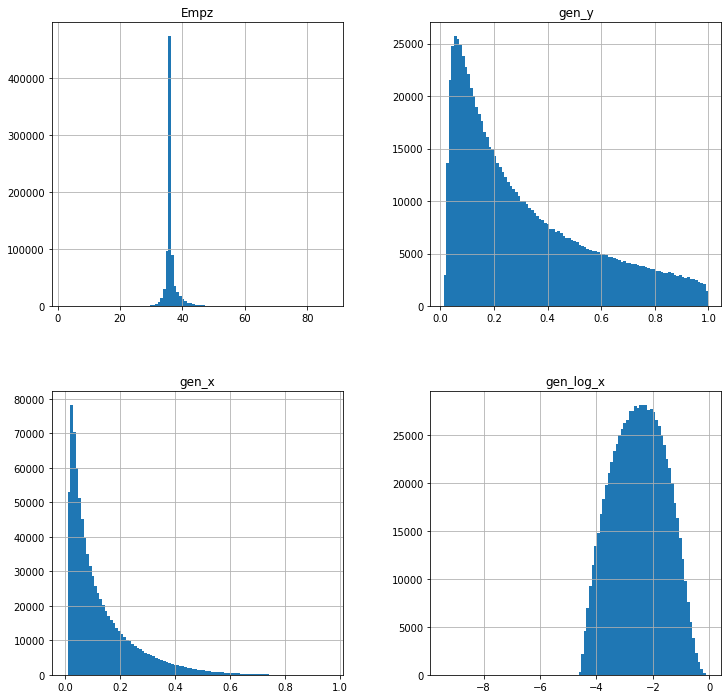

In [6]:
pandas_df.hist(figsize=(12,12), bins=100, column=['Empz','gen_y','gen_x','gen_log_x'])
plt.show()

In [7]:
pandas_df

,Q2_e,Q2_sigma,Q2_esigma,Q2_da,gen_Q2,y_e,y_sigma,y_esigma,y_da,HFS_px,...,e_phi,gene_pt,gene_phi,dphi,gen_dphi,HFS_Empz,e_Empz,gene_Empz,s,gen_log_x
entry,,,,,,,,,,,,,,,,,,,,,
0,216.864288,217.468460,216.864288,216.280685,216.045242,0.019574,0.022298,0.022236,0.022213,-2.647459,...,-1.426868,14.526401,-1.426868,3.103668,3.141593,0.804962,35.294956,35.161659,19800.000000,-0.757663
1,306.863068,306.146484,306.863068,303.670715,307.361481,0.106483,0.104391,0.104636,0.115778,1.224772,...,1.617904,16.585499,1.617904,3.105514,3.141593,3.749306,32.166512,32.218758,19800.000000,-1.911919
2,735.780151,731.354004,735.780151,727.638916,736.793213,0.274793,0.270404,0.272040,0.282817,4.856617,...,1.782560,23.131441,1.782560,3.127743,3.141593,9.675938,26.107389,26.143335,19799.998047,-1.995751
3,347.847839,341.010986,347.847839,358.594727,346.915100,0.216554,0.200847,0.204873,0.192349,1.461978,...,-1.673277,16.463921,-1.673277,3.123133,3.141593,7.088352,28.204018,28.128399,19800.000000,-2.524093
4,208.233643,207.290375,208.233643,209.089722,209.455582,0.090303,0.086163,0.086555,0.086563,-6.356885,...,-1.236457,13.844110,-1.236457,2.993182,3.141593,3.087811,32.749016,32.941193,19800.000000,-2.083401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848006,231.740311,228.462952,231.740311,230.296082,233.766251,0.201764,0.190313,0.193043,0.206739,12.076897,...,-2.864555,13.719767,-2.864555,3.242687,3.141593,6.754365,28.736458,28.987680,19800.000000,-2.803259
848007,335.045197,404.415710,335.045197,340.843689,336.375671,0.245166,0.374645,0.310381,0.232102,-25.955360,...,0.543163,15.966090,0.543163,3.081411,3.141593,16.279697,27.173973,27.281883,19800.000000,-2.657088
848008,432.683716,452.536285,432.683716,436.691010,432.477448,0.219613,0.253848,0.242712,0.212386,13.940497,...,2.193077,18.366787,2.193077,3.118727,3.141593,9.557819,28.093863,28.080475,19800.000000,-2.309711


## Set up machine learning stuff

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

#os.environ['CUDA_VISIBLE_DEVICES']="0"

print(tf.config.list_physical_devices())

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices = tf.config.list_physical_devices('CPU') 




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Test with gen electron vars only

Should be a slam dunk.

In [9]:
X = np.c_[ 
          pandas_df['gene_pz'].to_numpy(),
          pandas_df['gene_e'].to_numpy(),
          pandas_df['gene_pt'].to_numpy(),
          pandas_df['gene_Empz'].to_numpy(),
         ]

#Y = pandas_df['gen_x'].to_numpy()
Y = pandas_df['gen_log_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

print('\n\n Shape of X')
print( X.shape )

print('\n\n Shape of Y')
print( Y.shape )



 Shape of X
(848011, 4)


 Shape of Y
(848011, 1)


In [10]:
X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)

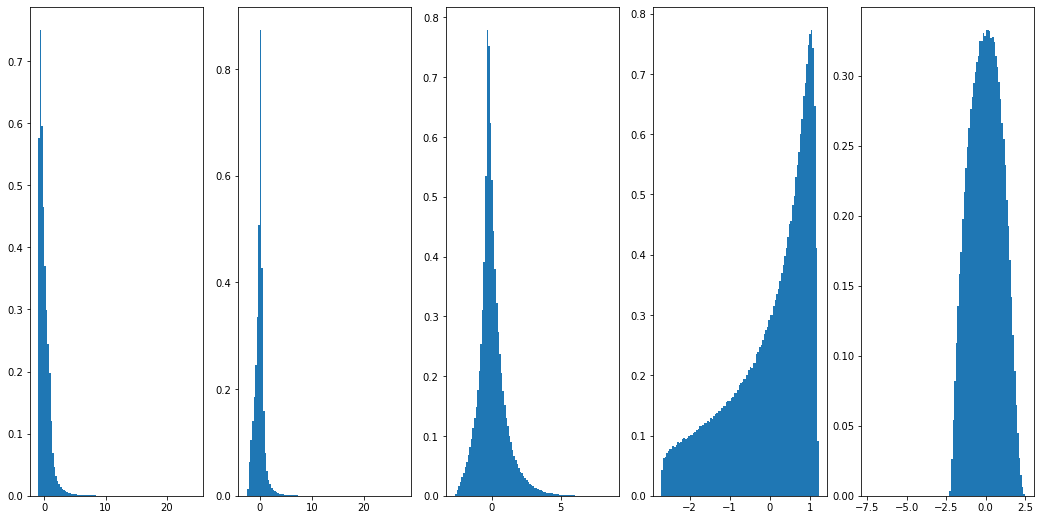

In [11]:
fig,ax = plt.subplots(1,5,figsize=(18,9))
for i in range(4):
    ax[i].hist( X[:,i],density=True,bins=100)

ax[4].hist( Y[:,0],density=True,bins=100)
plt.show()

In [12]:
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='selu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [13]:
%%time

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0243 - accuracy: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 2/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 3/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 4/5000
1657/1657 [==============================] - 6s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 5/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 6/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 7/5000
1657/1657 [==============================] - 7s 4ms/step - loss

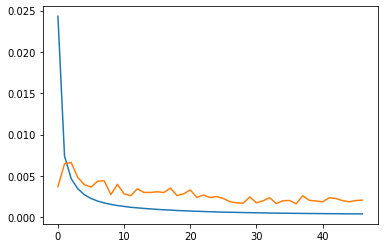

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

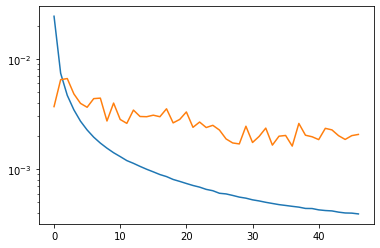

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

In [16]:
mypreds = model.predict(X_test,batch_size=1000)

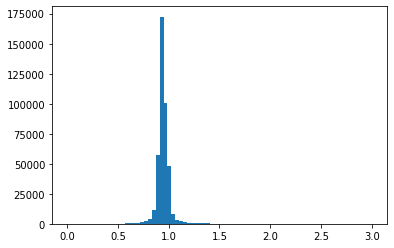

In [17]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

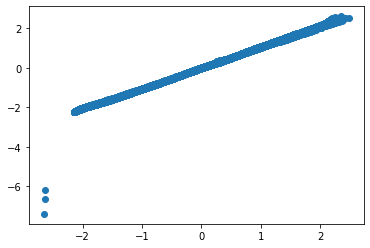

In [18]:
plt.scatter(mypreds[:,0],Y_test[:,0])

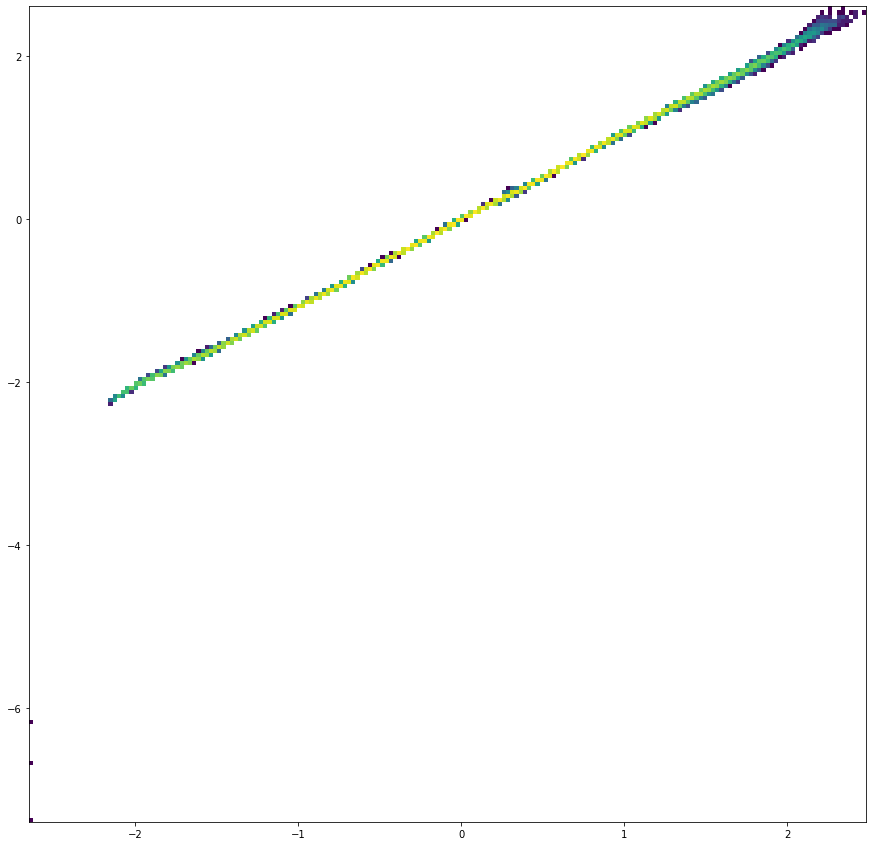

In [19]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

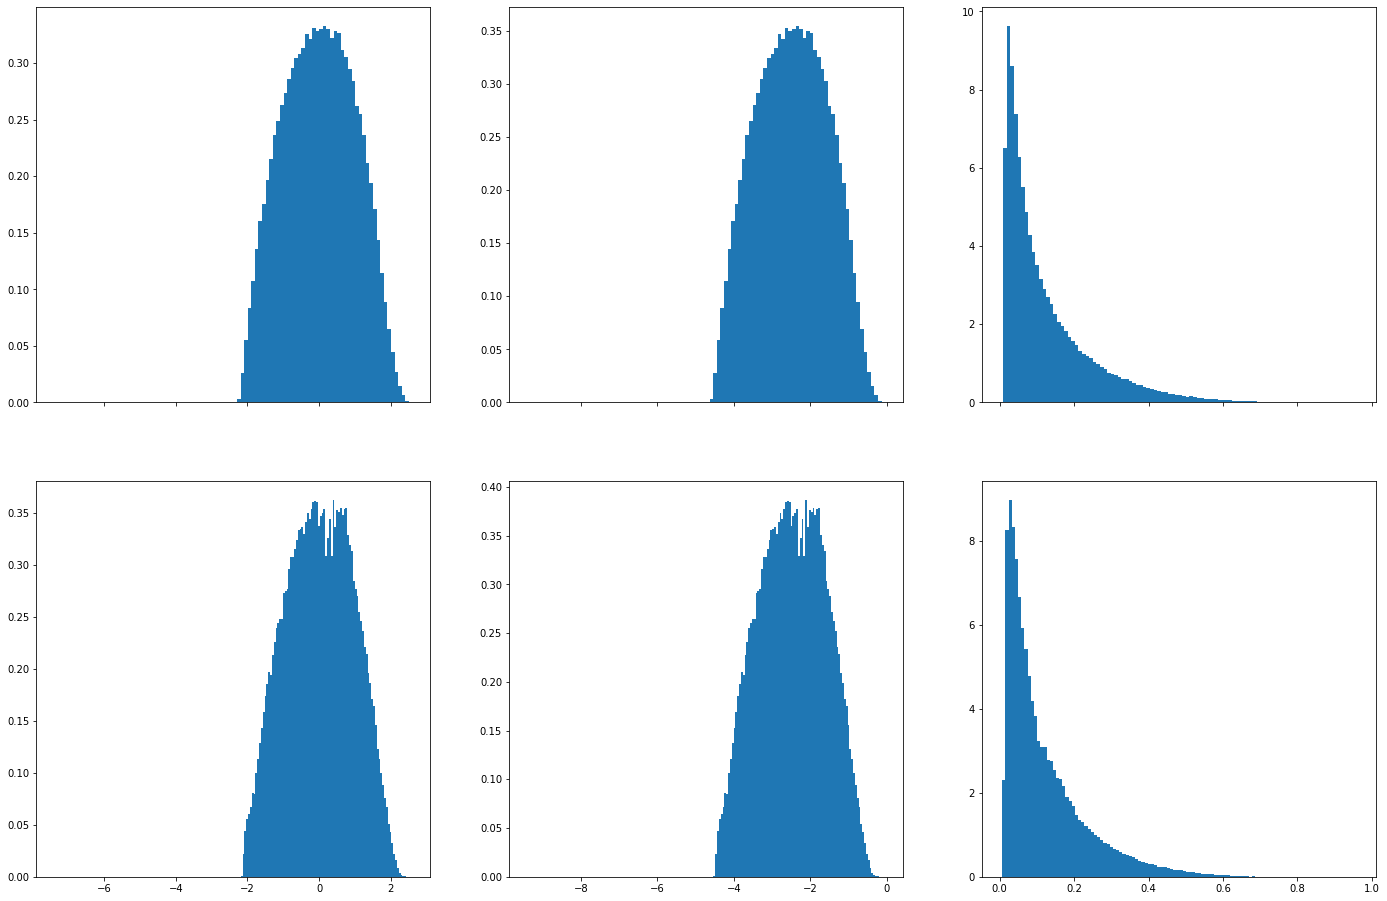

In [20]:
fig,ax = plt.subplots(2,3,figsize=(24,16), sharex='col')

ax[0][0].hist(Y_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY.inverse_transform(Y_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY.inverse_transform(Y_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds[:,0],density=True,bins=100)
ax[1][1].hist(scalerY.inverse_transform(mypreds)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY.inverse_transform(mypreds)[:,0]),density=True,bins=100)

plt.show()

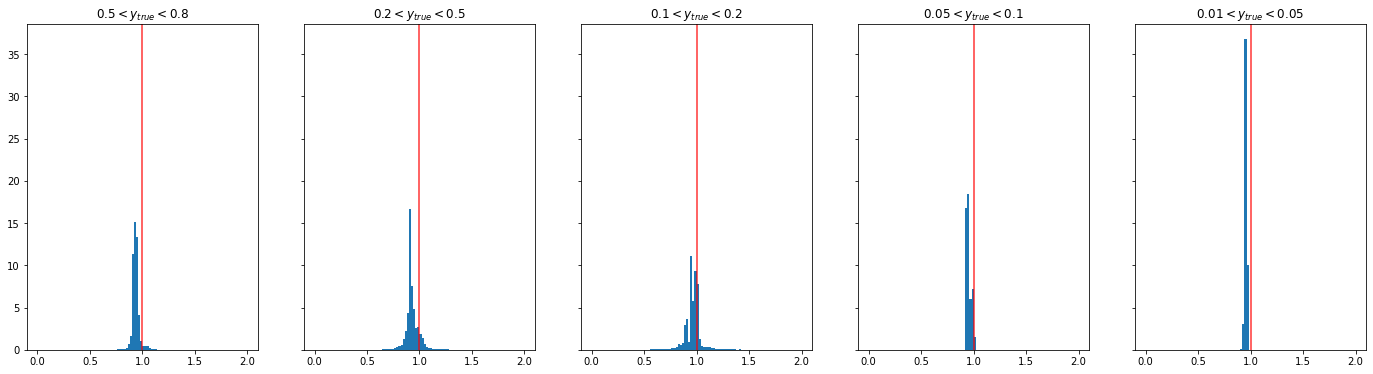

In [21]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()



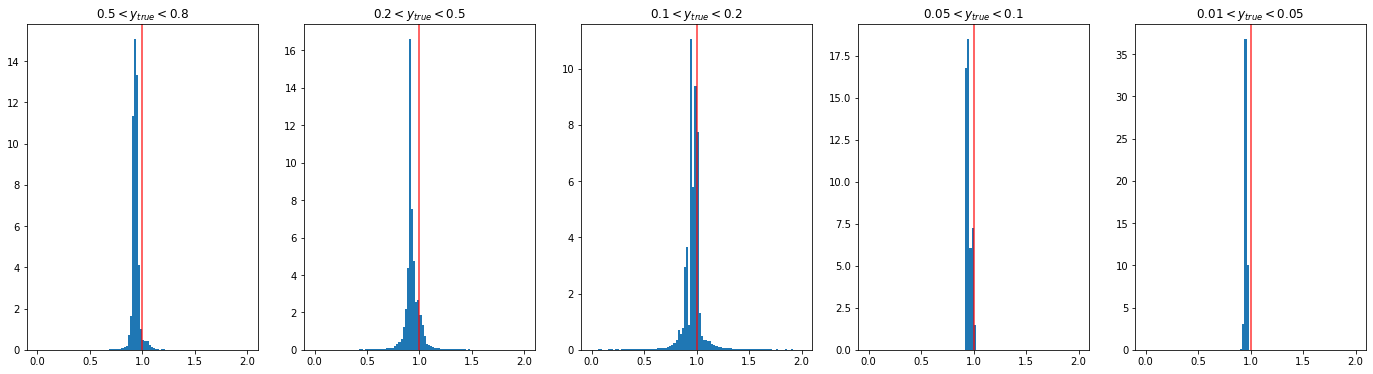

In [22]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)

plt.show()

## Conclusions on gen e vars only

Works, but sensitive to size of training sample and learning rate.  Can get artifacts if those are not right.

## Test with reco e vars only

This should be similar to the simple e method results.

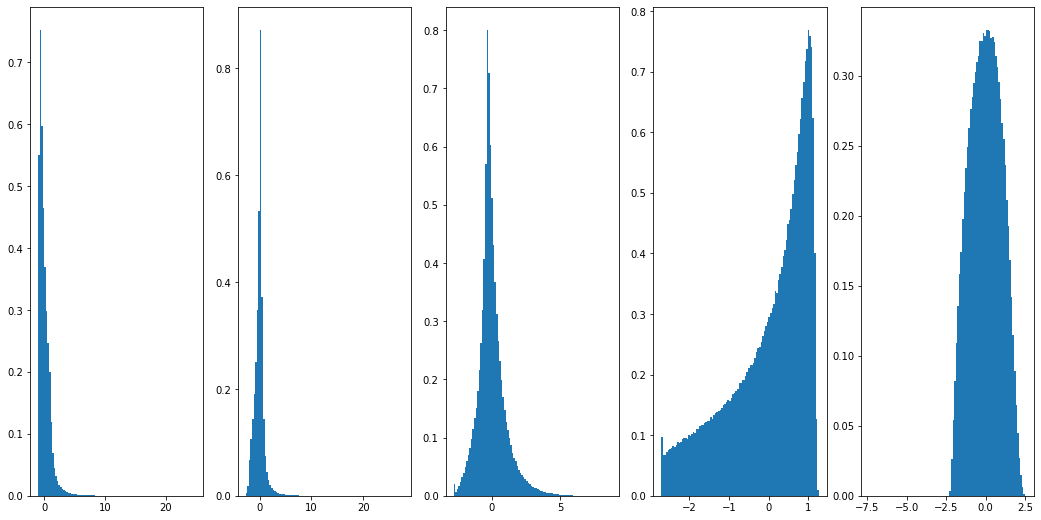

In [23]:
X2 = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
         ]

Y2 = pandas_df['gen_log_x'].to_numpy()

scaler2 = StandardScaler()
scaler2.fit(X2)
X2 = scaler.transform(X2)

Y2 = Y2.reshape(-1,1)
scalerY2 = StandardScaler()
scalerY2.fit(Y2)
Y2 = scalerY2.transform(Y2)

GY2 = pandas_df['gen_y'].to_numpy()

X2_train, X2_test, Y2_train, Y2_test, GY2_train, GY2_test = train_test_split( X2, Y2, GY2, test_size=0.5)

fig,ax = plt.subplots(1,5,figsize=(18,9))
for i in range(4):
    ax[i].hist( X2[:,i],density=True,bins=100)

ax[4].hist( Y2[:,0],density=True,bins=100)
plt.show()

In [24]:
model2 = Sequential()
model2.add(Dense(64, input_dim=4, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='selu'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation='selu'))
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='selu'))
model2.add(Dropout(0.1))
model2.add(Dense(64, activation='selu'))
model2.add(Dense(1, activation='linear'))

opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss2 = tf.keras.losses.Huber()

model2.compile(loss=myloss2, optimizer=opt2, metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [25]:
%%time

hist2 = model2.fit(
    X2_train, Y2_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X2_test,Y2_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
1657/1657 [==============================] - 9s 5ms/step - loss: 0.0328 - accuracy: 0.0000e+00 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 2/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0123 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 3/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0092 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 4/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 5/5000
1657/1657 [==============================] - 9s 5ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 6/5000
1657/1657 [==============================] - 10s 6ms/step - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 7/5000
1657/1657 [==============================] - 10s 6ms/step - lo

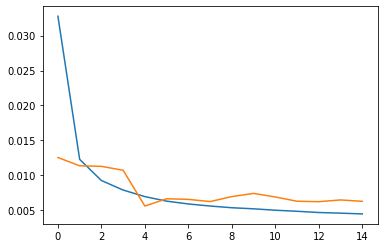

In [26]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

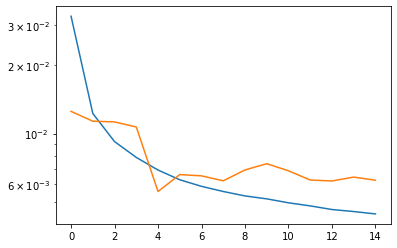

In [27]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.yscale('log')

In [28]:
mypreds2 = model2.predict(X2_test,batch_size=1000)

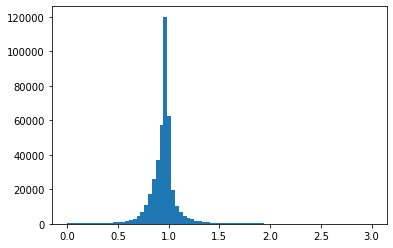

In [29]:
_,_,_=plt.hist(mypreds2[:,0]/Y2_test[:,0],bins=np.linspace(0,3,80))

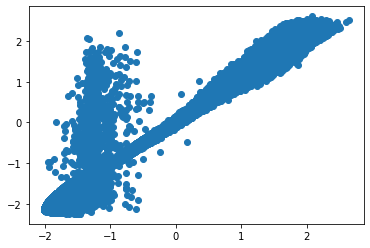

In [30]:
plt.scatter(mypreds2[:,0],Y2_test[:,0])

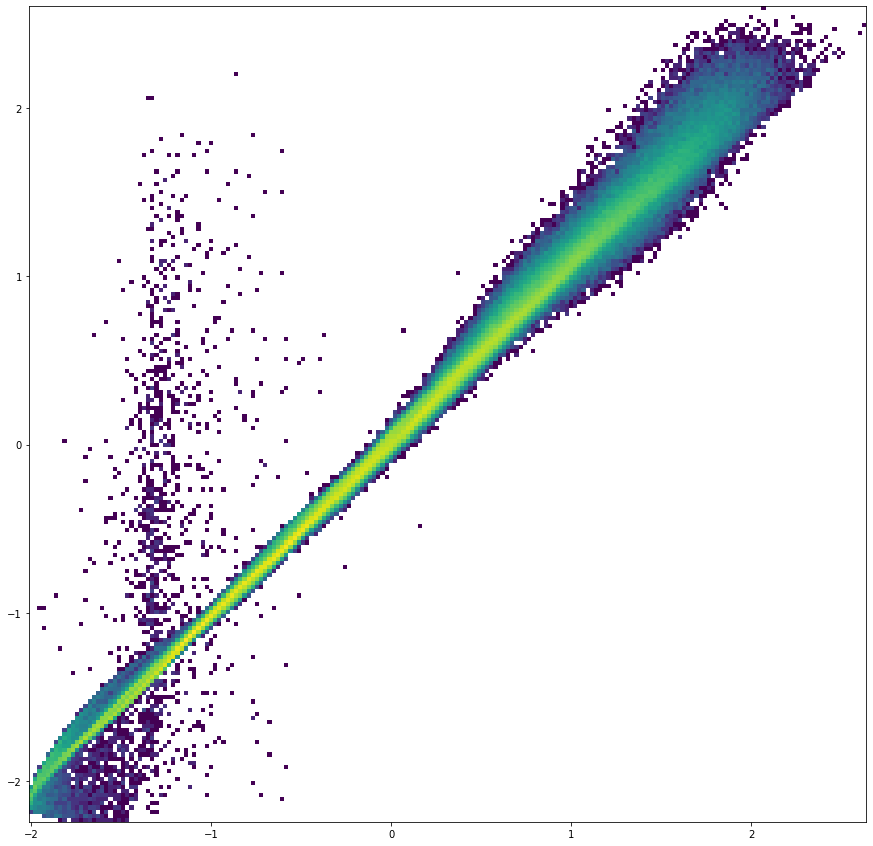

In [31]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds2[:,0],Y2_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

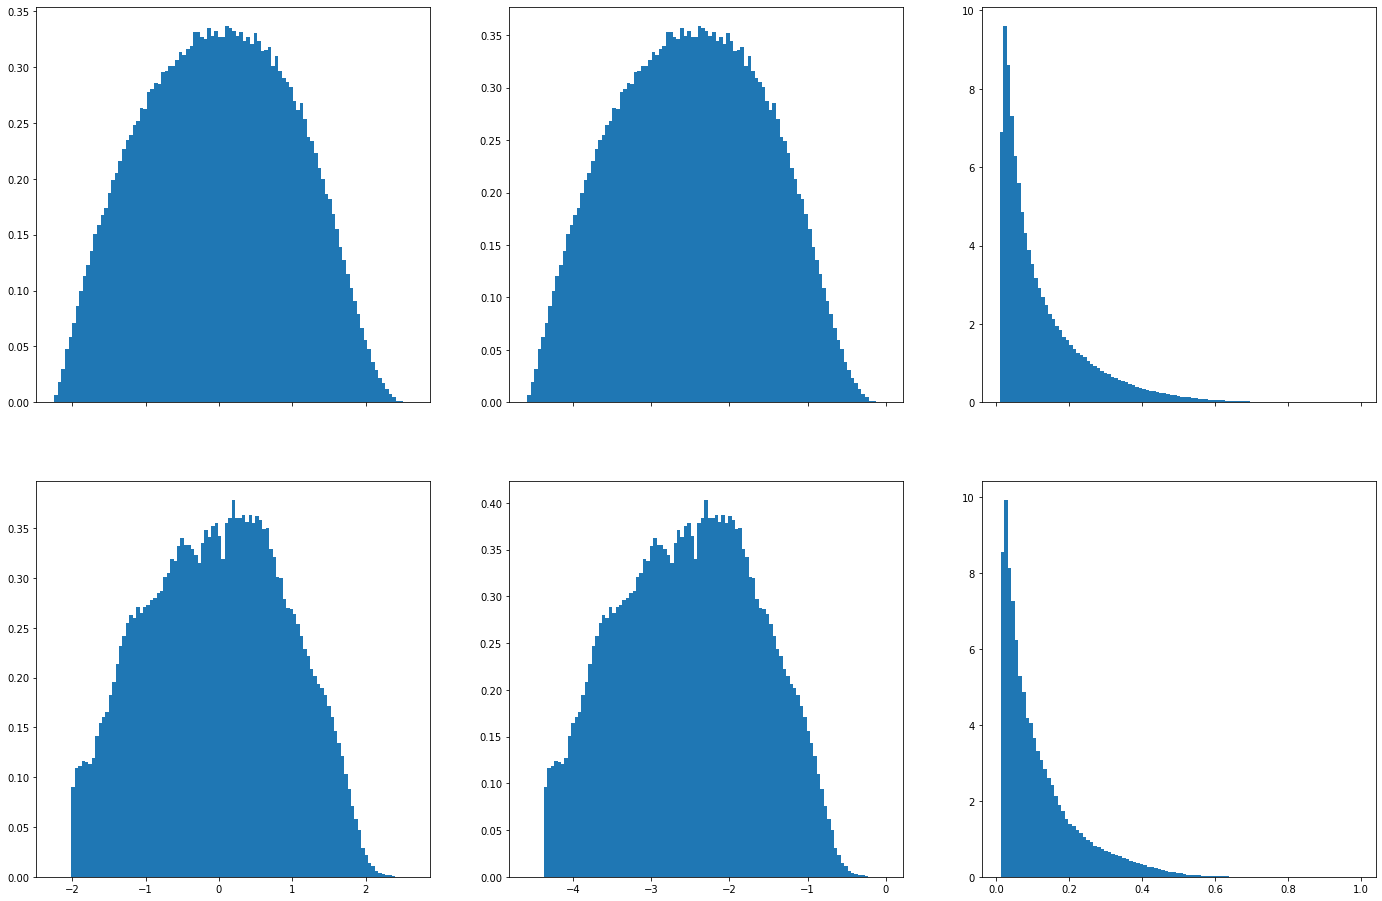

In [32]:
fig,ax = plt.subplots(2,3,figsize=(24,16),sharex='col')

ax[0][0].hist(Y2_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY2.inverse_transform(Y2_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY2.inverse_transform(Y2_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds2[:,0],density=True,bins=100)
ax[1][1].hist(scalerY2.inverse_transform(mypreds2)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY2.inverse_transform(mypreds2)[:,0]),density=True,bins=100)

plt.show()

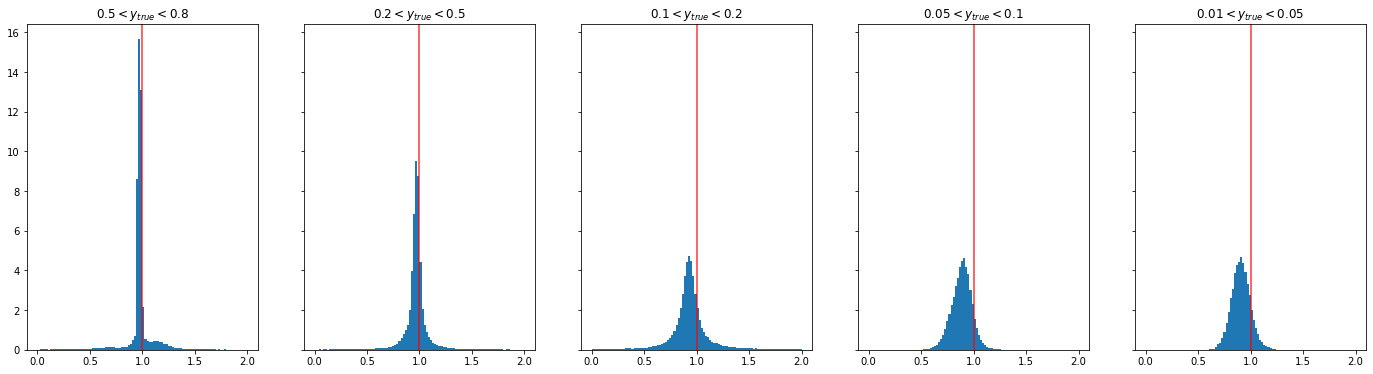

In [33]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds2[:,0][(GY2_test > 0.5)*(GY2_test < 0.8)]/Y2_test[(GY2_test > 0.5)*(GY2_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds2[:,0][(GY2_test > 0.2)*(GY2_test < 0.5)]/Y2_test[(GY2_test > 0.2)*(GY2_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds2[:,0][(GY2_test > 0.1)*(GY2_test < 0.2)]/Y2_test[(GY2_test > 0.1)*(GY2_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds2[:,0][(GY2_test > 0.05)*(GY2_test < 0.1)]/Y2_test[(GY2_test > 0.05)*(GY2_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds2[:,0][(GY2_test > 0.01)*(GY2_test < 0.05)]/Y2_test[(GY2_test > 0.01)*(GY2_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()




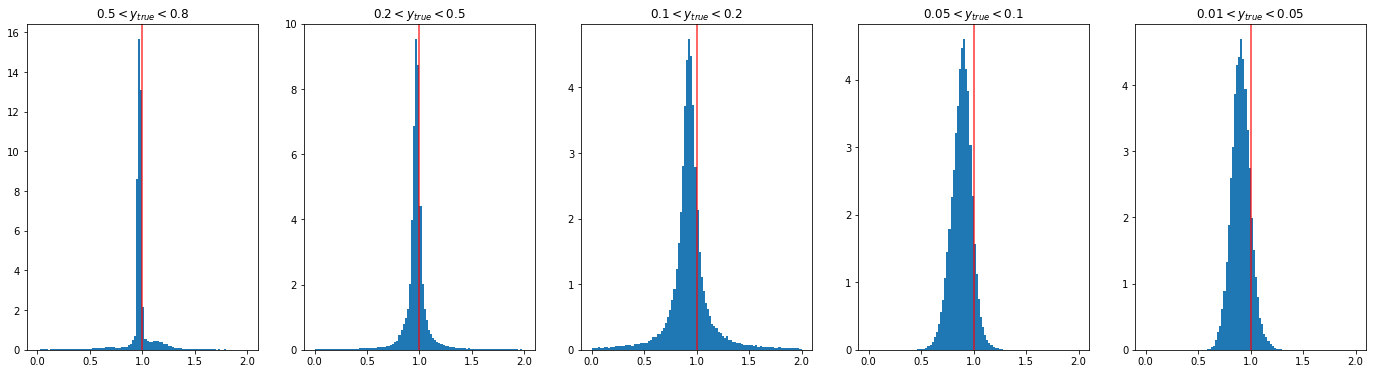

In [34]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds2[:,0][(GY2_test > 0.5)*(GY2_test < 0.8)]/Y2_test[(GY2_test > 0.5)*(GY2_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds2[:,0][(GY2_test > 0.2)*(GY2_test < 0.5)]/Y2_test[(GY2_test > 0.2)*(GY2_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds2[:,0][(GY2_test > 0.1)*(GY2_test < 0.2)]/Y2_test[(GY2_test > 0.1)*(GY2_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds2[:,0][(GY2_test > 0.05)*(GY2_test < 0.1)]/Y2_test[(GY2_test > 0.05)*(GY2_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds2[:,0][(GY2_test > 0.01)*(GY2_test < 0.05)]/Y2_test[(GY2_test > 0.01)*(GY2_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Conclusions on reco electron vars only

More or less looks as expected.  Resolution gets very poor at low y.

## Now feed in reco electron and reco HFS

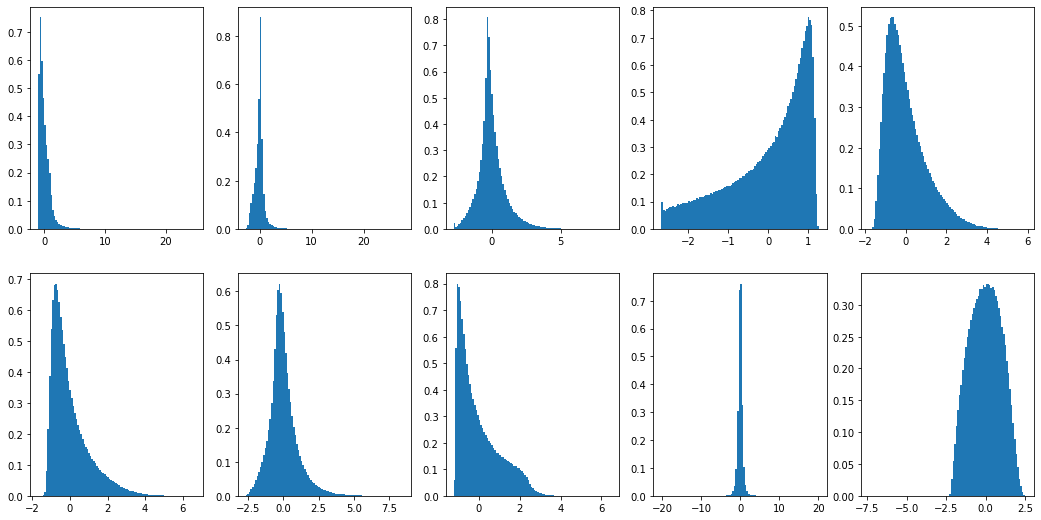

In [35]:
X3 = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
          pandas_df['HFS_pz'].to_numpy(),
          pandas_df['HFS_E'].to_numpy(),
          pandas_df['HFS_pt'].to_numpy(),
          pandas_df['HFS_Empz'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y3 = pandas_df['gen_log_x'].to_numpy()

scaler3 = StandardScaler()
scaler3.fit(X3)
X3 = scaler3.transform(X3)

Y3 = Y3.reshape(-1,1)
scalerY3 = StandardScaler()
scalerY3.fit(Y3)
Y3 = scalerY3.transform(Y3)

GY3 = pandas_df['gen_y'].to_numpy()

X3_train, X3_test, Y3_train, Y3_test, GY3_train, GY3_test = train_test_split( X3, Y3, GY3, test_size=0.5)

fig,ax = plt.subplots(2,5,figsize=(18,9))
for i in range(5):
    ax[0][i].hist( X3[:,i],density=True,bins=100)
for i in range(4):
    ax[1][i].hist( X3[:,i+5],density=True,bins=100)

ax[1][4].hist( Y3[:,0],density=True,bins=100)
plt.show()

In [36]:
model3 = Sequential()
model3.add(Dense(64, input_dim=9, activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(256, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(64, activation='selu'))
model3.add(Dense(1, activation='linear'))

opt3 = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss3 = tf.keras.losses.Huber()

model3.compile(loss=myloss3, optimizer=opt3, metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)              

In [37]:
%%time

hist3 = model3.fit(
    X3_train, Y3_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X3_test,Y3_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0324 - accuracy: 0.0000e+00 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 2/5000
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0117 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 3/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 4/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0117 - val_accuracy: 0.0000e+00
Epoch 5/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 6/5000
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 7/5000
1657/1657 [==============================] - 8s 5ms/step - loss

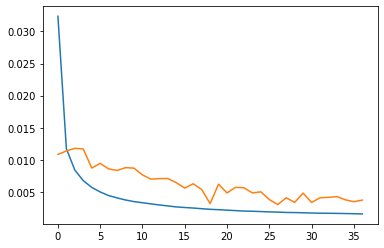

In [38]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

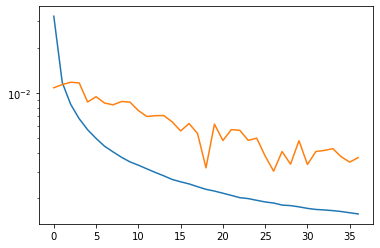

In [39]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.yscale('log')

In [40]:
mypreds3 = model3.predict(X3_test,batch_size=1000)

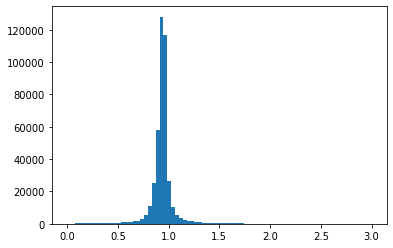

In [41]:
_,_,_=plt.hist(mypreds3[:,0]/Y3_test[:,0],bins=np.linspace(0,3,80))

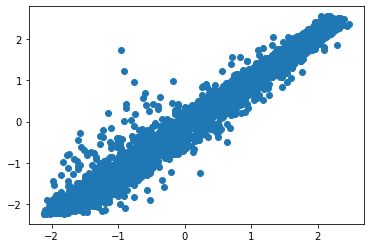

In [42]:
plt.scatter(mypreds3[:,0],Y3_test[:,0])

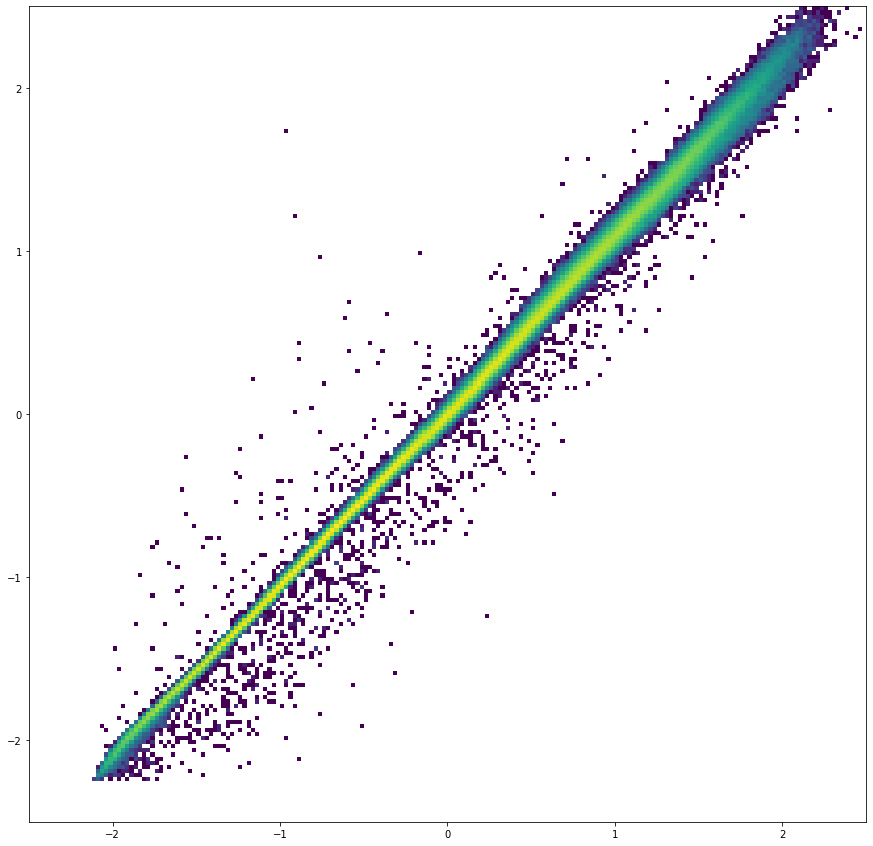

In [43]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds3[:,0],Y3_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

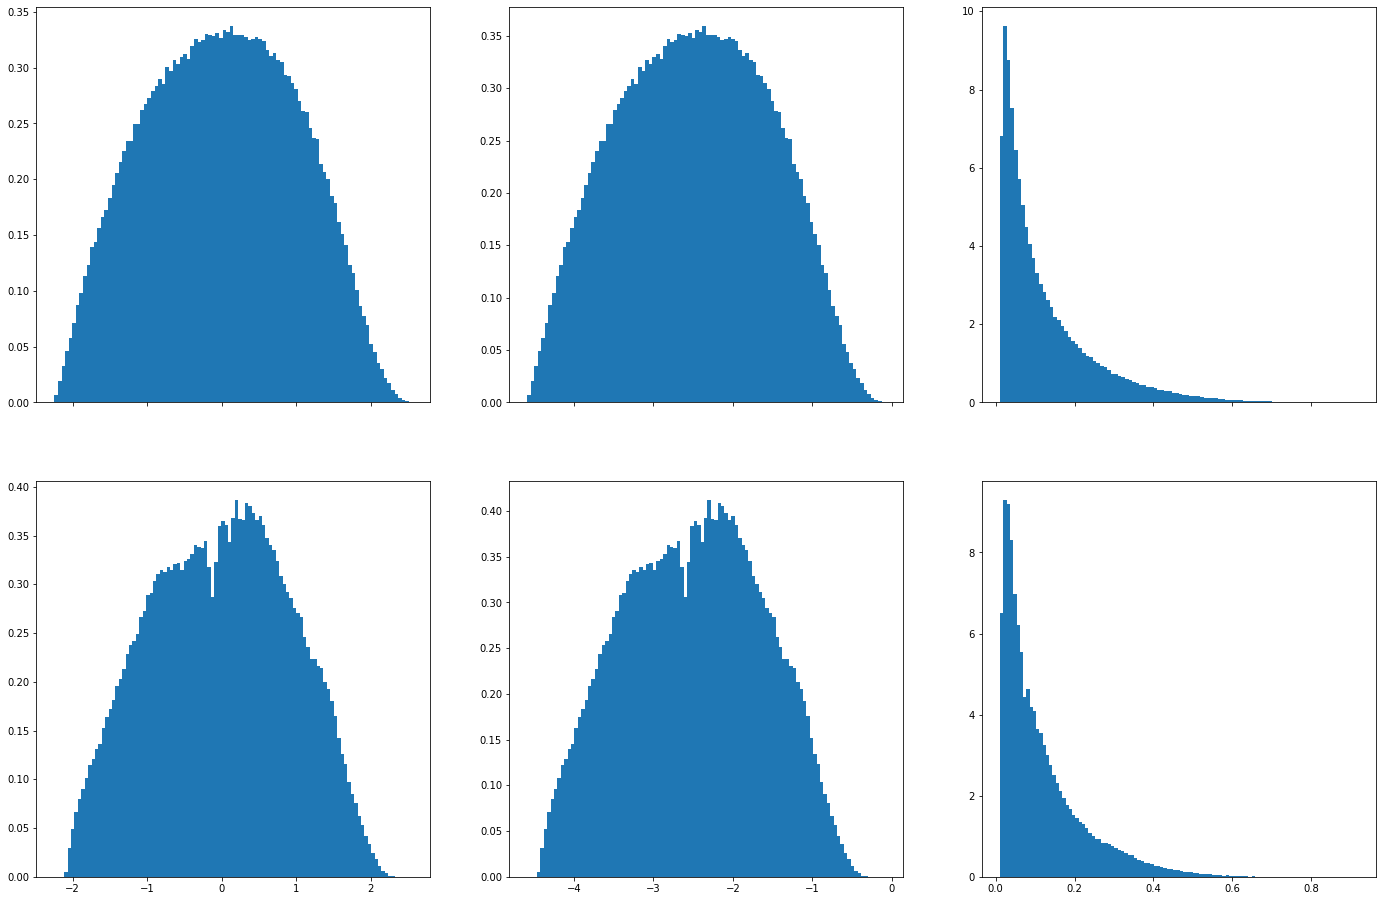

In [44]:
fig,ax = plt.subplots(2,3,figsize=(24,16), sharex='col')

ax[0][0].hist(Y3_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY3.inverse_transform(Y3_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY3.inverse_transform(Y3_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds3[:,0],density=True,bins=100)
ax[1][1].hist(scalerY3.inverse_transform(mypreds3)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY3.inverse_transform(mypreds3)[:,0]),density=True,bins=100)

plt.show()

## Plots of pred/true of training target variable : log(x)

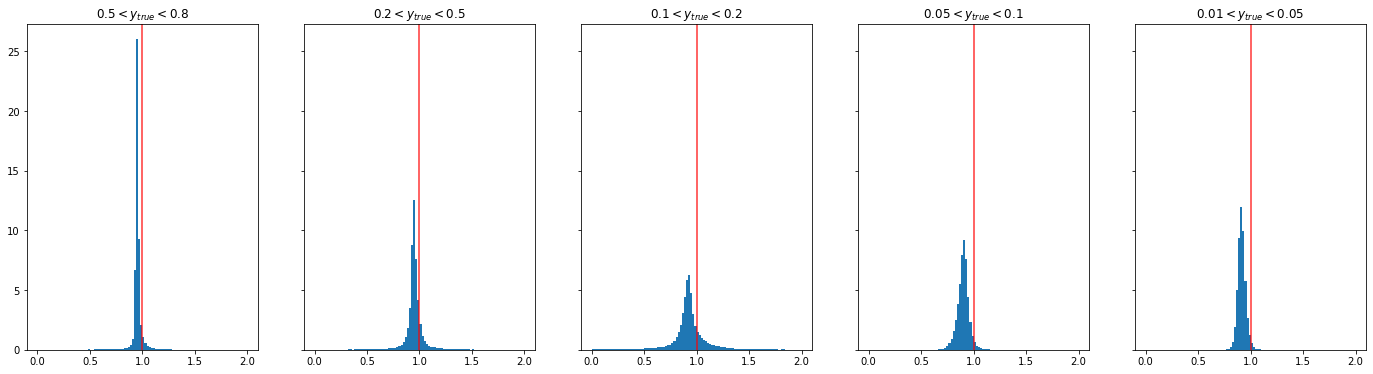

In [45]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()



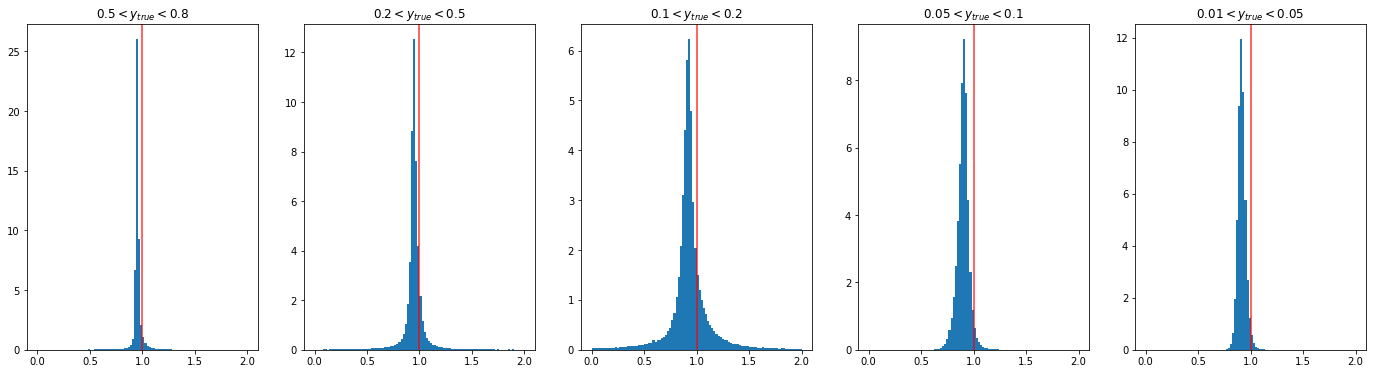

In [46]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

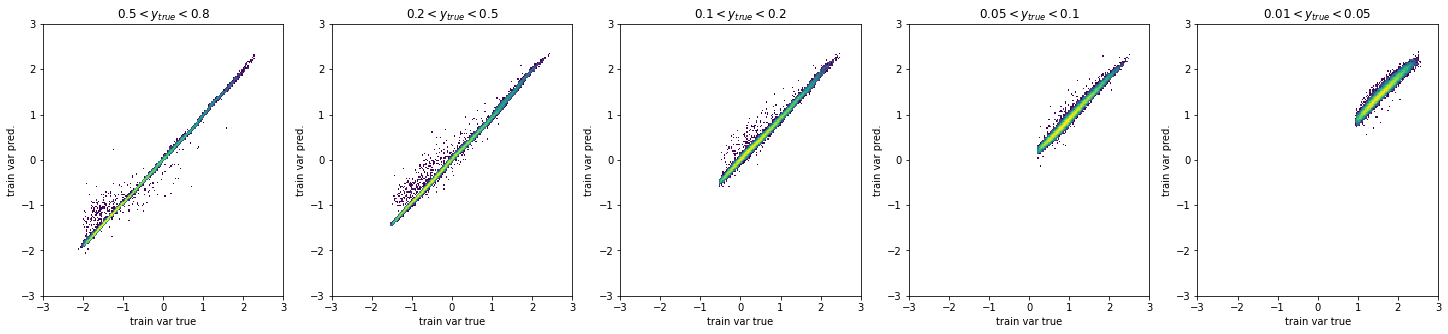

In [54]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1].hist2d( Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[2].hist2d( Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[3].hist2d( Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[4].hist2d( Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())





ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('train var pred.')
    ax[i].set_xlabel('train var true')


    
plt.show()

## Plots of predicted and true physics variable : x

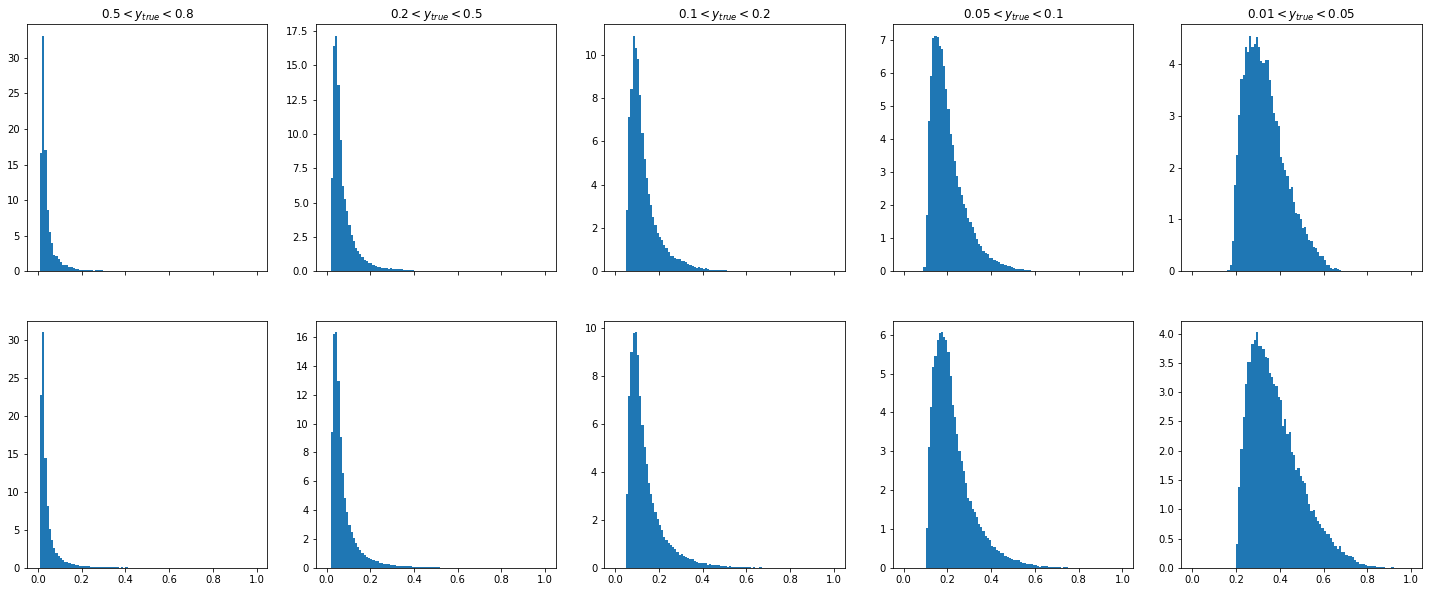

In [48]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,1))
ax[1][1].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,1))
ax[1][2].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,1))
ax[1][3].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,1))
ax[1][4].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

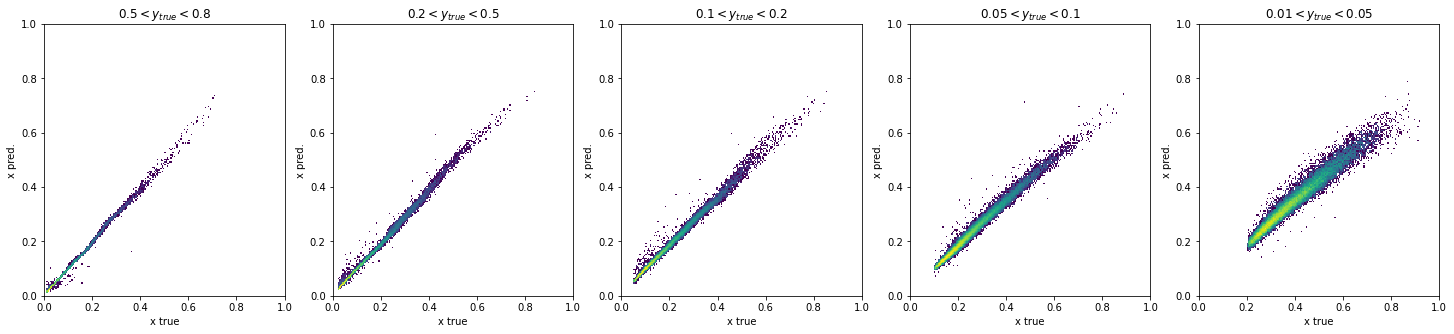

In [49]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())





ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of pred/true of physics variable:  x

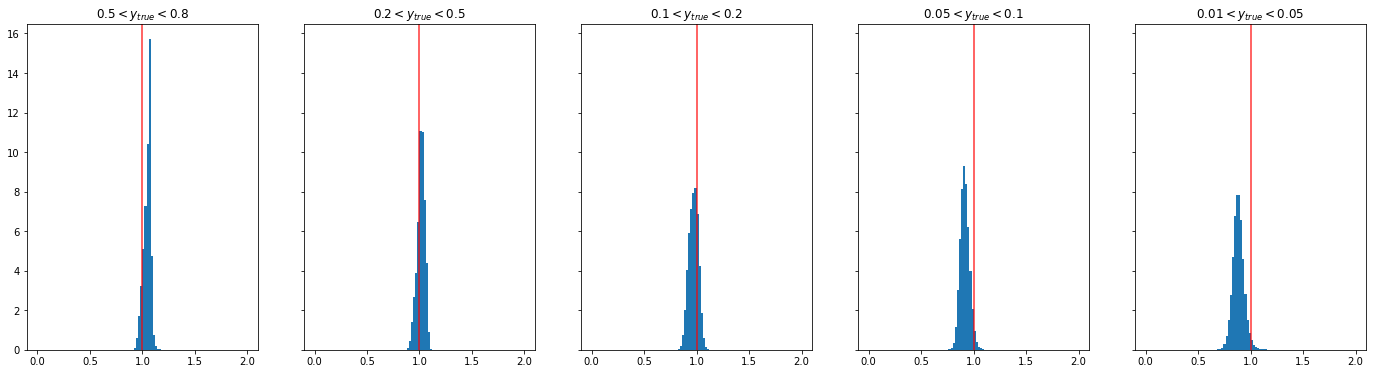

In [50]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Conclusions 

Larger training stats don't necessarily give far superior results.


## Standard comparison plots

In [51]:

pandas_df.eval('s = 4*27.6*920', inplace=True)
pandas_df.eval('x_e = Q2_e/(s*y_e)',inplace=True)
pandas_df.eval('x_da = Q2_da/(s*y_da)',inplace=True)
pandas_df.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
pandas_df.eval('x_esigma = x_sigma',inplace=True)



pandas_df.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

pandas_df.eval('xe_ratio = x_e/gen_x',inplace=True)
pandas_df.eval('xda_ratio = x_da/gen_x',inplace=True)
pandas_df.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
pandas_df.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


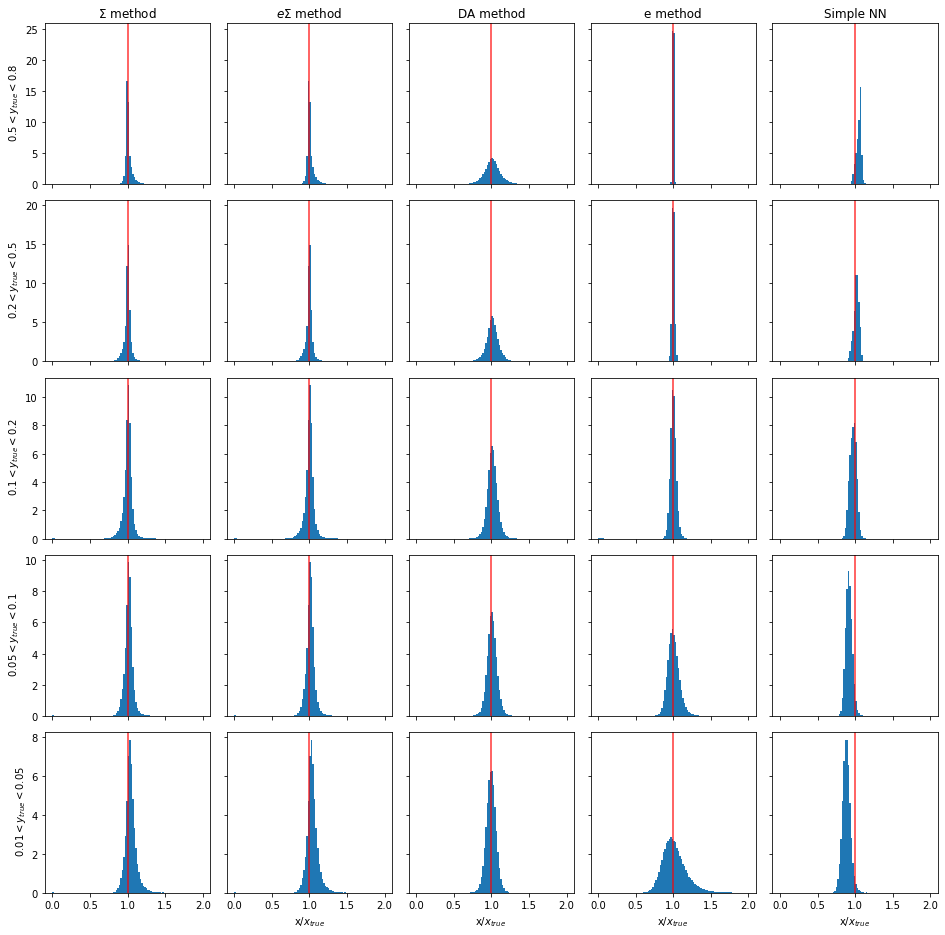

In [52]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.
xmax=2.

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

## Make standard plots with the x axis zoomed in more near 1.

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


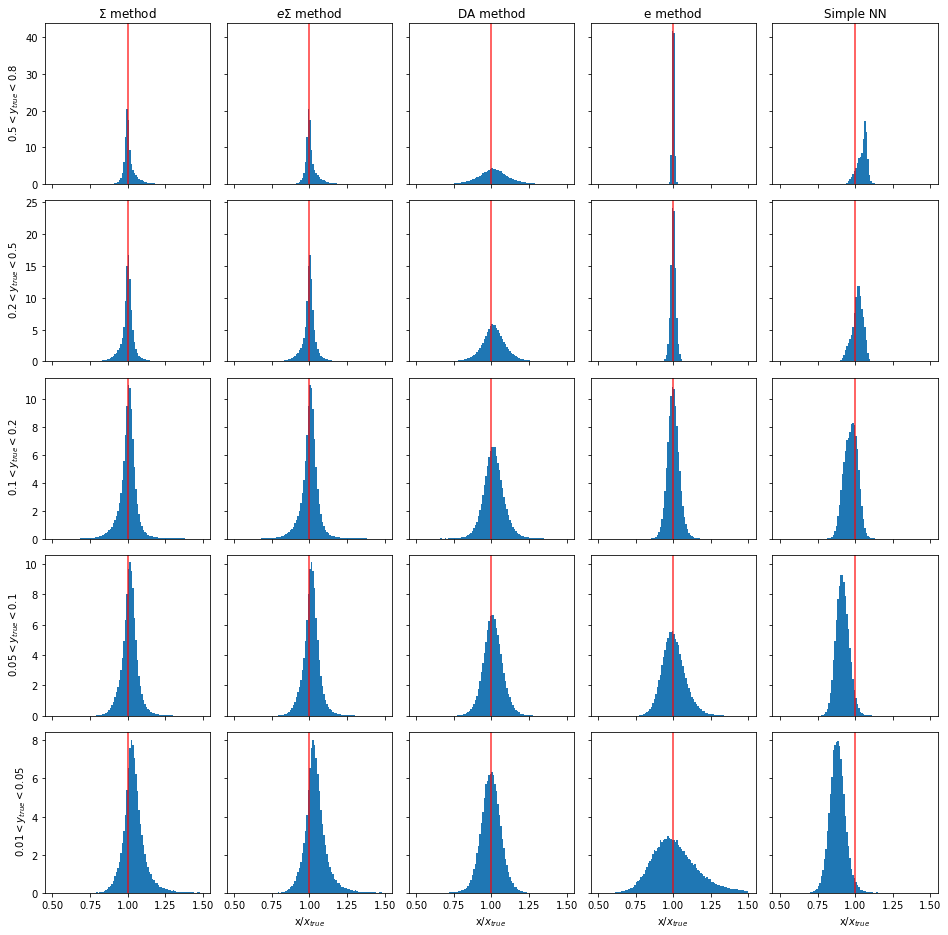

In [53]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.5
xmax=1.5

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()